C:\Users\eliza\PycharmProjects\SC-generation-stimulation\laserfun\nlse.py:119: RuntimeWarning: overflow encountered in exp
  rt = (t1**2+t2**2)/t1/t2**2*exp(-t/t2)*sin(t/t1)
C:\Users\eliza\PycharmProjects\SC-generation-stimulation\laserfun\nlse.py:119: RuntimeWarning: overflow encountered in multiply
  rt = (t1**2+t2**2)/t1/t2**2*exp(-t/t2)*sin(t/t1)


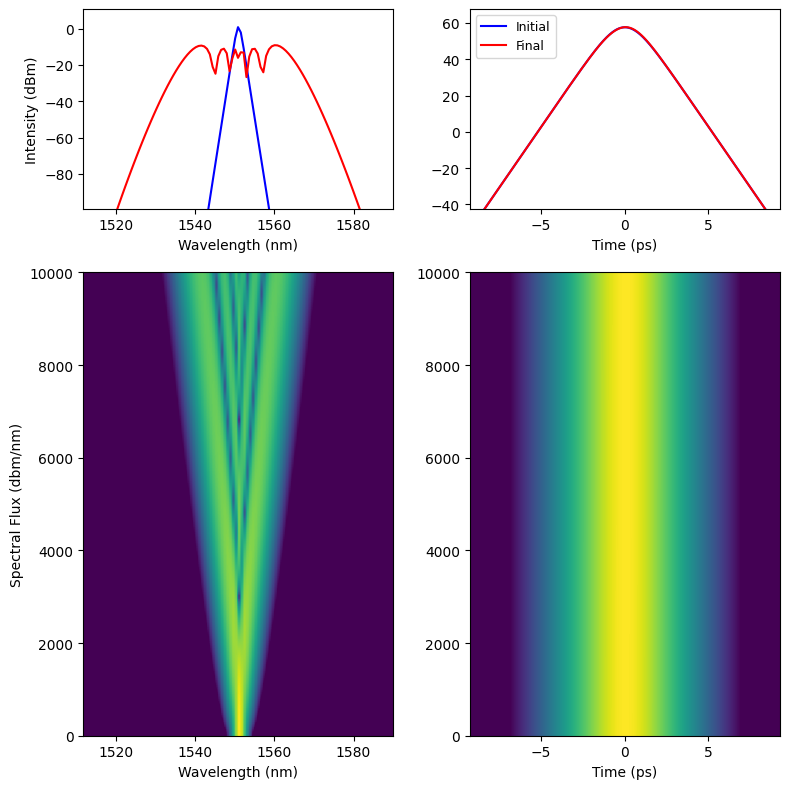

(<Figure size 800x800 with 4 Axes>,
 array([[<Axes: xlabel='Wavelength (nm)', ylabel='Intensity (dBm)'>,
         <Axes: xlabel='Time (ps)'>],
        [<Axes: xlabel='Wavelength (nm)', ylabel='Spectral Flux (dbm/nm)'>,
         <Axes: xlabel='Time (ps)'>]], dtype=object))

In [2]:
from typing import OrderedDict
import shapely
import laserfun as lf
from generate_neff_and_aeff import get_neff_and_aeff
from collections import OrderedDict
import scipy
import numpy as np

# pulse parameters
FWHM = 0.20           # pulse duration (ps)
pulseWL = 1560        # pulse central wavelength (nm)

power = 0.022
rep_rate = 1.3e8

EPP = power/rep_rate  # Energy per pulse (J)
#EPP = 170e-12
print(EPP)

GDD = True            # Group delay dispersion (ps^2)
TOD = False           # Third order dispersion (ps^3)
FOD = False           # Fourth order dispersion

# simulation parameters
Window = 3.0    # simulation window (ps)
Steps = 100     # simulation steps
Points = 2**12  # simulation points
rtol = 1e-4     # relative error for NLSE integrator
atol = 1e-4     # absolute error
Raman = True    # Enable Raman effect?
Steep = False   # Enable self steepening?

# ----------- Build Pulse -----------
pulse = lf.Pulse(pulse_type='sech', center_wavelength_nm=1551,
                 fwhm_ps=1.3 * 1.76, time_window_ps=100, power=1, power_is_avg=True, frep_MHz=507.614)

# ----------- Build Waveguide -----------
# waveguide parameters
width = 2.3      # micron
n2 = 2.0e-19     # m^2/W n2 is the nonlinear refractive index at the center(pump) frequency # TODO: get from internet?
Length = 21.05   # length in mm
Alpha = 0.0      # loss (dB/cm)

wavelength_range = [0,3000]
wavelegnth_step = 300
capital_w = 1.4
capital_h = 0.3
h = 0.5
t = 0.1
width = 0.25
n_silicon = 3.48
n_air = 1
n_nc = 1.6
n_silica = 1.45

# Construct waveguide geometry
nc = shapely.geometry.box(-width / 2, capital_h + (h - t) / 2, +width / 2, capital_h + (h - t) / 2 + t)
silica = shapely.geometry.box(-capital_w / 2, 0, +capital_w / 2, capital_h)
silicon = shapely.geometry.box(-width / 2, capital_h, +width / 2, capital_h + h)
polygons = OrderedDict(core=nc, silicon=silicon, silica=silica, air=nc.buffer(10.0, resolution=4))

# Define material property and resolution of waveguide
resolutions = dict(core={"resolution": 0.02, "distance": 0.3},
                   silicon={"resolution": 0.02, "distance": 0.1},
                   silica={"resolution": 0.04, "distance": 0.5})

n_dict = {"core": n_nc,"silicon": n_silicon,"air": n_air,"silica": n_silica}

# Calculate dispersion and gamma
wls, aeff_list, neff_list = get_neff_and_aeff(polygons,n_dict,wavelength_range,wavelegnth_step,resolutions)

def disp_function(z=0):  # provide effective index to the NLSE
    return (wls, neff_list)


def gamma_function(z=0):  # provide the nonlinearity at the pump to the NLSE
    aeff_interp = scipy.interpolate.interp1d(wls, aeff_list)
    return 2*np.pi*n2/(pulseWL*1e-9*aeff_interp(pulseWL)*1e-12)

# create the pulse:
p = lf.Pulse(pulse_type='sech', fwhm_ps=FWHM, center_wavelength_nm=pulseWL,
             time_window_ps=Window, GDD=GDD, TOD=TOD, npts=Points, epp=EPP)

# create the waveguide
f = lf.Fiber(Length * 1e-3, center_wl_nm=pulseWL, dispersion_format='GVD',
             gamma_W_m=gamma_function(), loss_dB_per_m=Alpha*100)

f.set_dispersion_function(disp_function, dispersion_format='n')

# propagate the pulse using the NLSE
results = lf.NLSE(p, f, raman=Raman, shock=Steep, nsaves=Steps, rtol=rtol,
                  atol=atol, print_status=True)

results.plot(wavelength=True, show=True, tlim=(-2, 2))
